### Topic modeling using LSI

It is a technique in natural language processing, in particular distributional semantics, of analyzing relationships between a set of documents and the terms they contain by producing a set of concepts related to the documents and terms.

* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [1]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet

output_notebook()

Loading BokehJS ...

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
dbpedia_df = pd.read_csv('./datasets/dbpedia_csv/train.csv', 
                         skiprows=1, names = ['Label', 'Name', 'Text'])

In [8]:
dbpedia_df.shape

(559999, 3)

In [9]:
NUM_SAMPLES = 10000

In [10]:
dbpedia_df = dbpedia_df.sample(NUM_SAMPLES, replace=False).reset_index(drop=True)

In [11]:
dbpedia_df.head(5)

Label                               Name  \
0     14          Hornblower and the Crisis   
1      1                       Viper Comics   
2      9                           Jażyniec   
3     12                          Prvý Slíž   
4     14  The Selected Works of T.S. Spivet   

                                                Text  
0   Hornblower and the Crisis is a 1967 historica...  
1   Viper Comics based in Dallas Texas has been a...  
2   Jażyniec [jaˈʐɨɲet͡s] is a village in the adm...  
3   Prvý Slíž is the demo tape by the Slovak punk...  
4   The Selected Works of T.S. Spivet is the debu...

### DBPedia classes

- Company
- EducationalInstitution
- Artist
- Athlete
- OfficeHolder
- MeanOfTransportation
- Building
- NaturalPlace
- Village
- Animal
- Plant
- Album
- Film
- WrittenWork

In [12]:
sorted(dbpedia_df['Label'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [13]:
X = dbpedia_df['Text']

In [14]:
X.head()

0     Hornblower and the Crisis is a 1967 historica...
1     Viper Comics based in Dallas Texas has been a...
2     Jażyniec [jaˈʐɨɲet͡s] is a village in the adm...
3     Prvý Slíž is the demo tape by the Slovak punk...
4     The Selected Works of T.S. Spivet is the debu...
Name: Text, dtype: object

In [15]:
count_vectorizer = CountVectorizer(stop_words='english')

transformed_vector = count_vectorizer.fit_transform(X)

In [16]:
transformed_vector.shape

(10000, 47986)

In [17]:
feature_names = count_vectorizer.get_feature_names()

In [18]:
len(feature_names)

47986

In [19]:
feature_names[1000:1005]

['269', '26943', '26th', '27', '270']

In [40]:
NUM_TOPICS = 7

nmf_model = TruncatedSVD(n_components=NUM_TOPICS)

nmf = nmf_model.fit_transform(transformed_vector)

In [41]:
nmf.shape

(10000, 7)

In [42]:
nmf[:2]

array([[ 0.09970244,  0.05561103,  0.36121263,  0.22848283,  0.06187092,
        -0.05651207, -0.10610287],
       [ 0.11327381,  0.01678706,  0.2376305 ,  0.2282164 ,  0.0149802 ,
        -0.03370911, -0.05498887]])

Variational parameters for topic word distribution. lda_model.components_[t, w] can be viewed as pseudocount that represents the number of times the word w was assigned to topic t

In [43]:
nmf_model.components_.shape

(7, 47986)

In [44]:
def get_topic(identifier, top_words=10):
    
    for topic_id, topic_word_probs in enumerate(nmf_model.components_):

        if topic_id == identifier:
            top_feature_names = [feature_names[i] for i in topic_word_probs.argsort()[: -top_words - 1 : -1]]
            
            return " ".join(top_feature_names)

In [47]:
for i in range(NUM_TOPICS):
    print("Topic %d:" % (i))

    print(get_topic(i, top_words=3))

Topic 0:
school high district
Topic 1:
mi village district
Topic 2:
album released film
Topic 3:
film directed born
Topic 4:
river species mi
Topic 5:
film mi km
Topic 6:
species family genus


In [48]:
topic_id_topic_mapping = {}

for i in range(NUM_TOPICS):
    topic_id_topic_mapping[i] = get_topic(i, top_words=3)
    
topic_id_topic_mapping

{0: 'school high district',
 1: 'mi village district',
 2: 'album released film',
 3: 'film directed born',
 4: 'river species mi',
 5: 'film mi km',
 6: 'species family genus'}

In [49]:
topic_to_doc_mapping = {}
topic_list = []
topic_names = []

for i in range(NUM_SAMPLES):
    most_likely_topic =  nmf[i].argmax()

    if most_likely_topic not in topic_to_doc_mapping:
        topic_to_doc_mapping[most_likely_topic] = []

    topic_to_doc_mapping[most_likely_topic].append(i)

    topic_list.append(most_likely_topic)
    topic_names.append(topic_id_topic_mapping[most_likely_topic])

dbpedia_df['Most_Likely_Topic'] = topic_list
dbpedia_df['Most_Likely_Topic_Names'] = topic_names

In [50]:
print(topic_to_doc_mapping[0][:100])

[7, 16, 25, 34, 61, 64, 66, 82, 86, 89, 96, 97, 112, 125, 126, 127, 130, 133, 136, 137, 157, 167, 172, 192, 199, 201, 204, 205, 216, 218, 224, 233, 243, 247, 252, 257, 260, 264, 273, 283, 300, 302, 304, 309, 317, 321, 335, 342, 349, 361, 367, 371, 377, 386, 391, 401, 402, 412, 418, 427, 430, 433, 451, 453, 458, 466, 477, 491, 492, 493, 495, 500, 503, 504, 507, 509, 518, 522, 524, 526, 535, 539, 542, 546, 554, 570, 582, 593, 598, 606, 607, 614, 617, 624, 632, 633, 637, 655, 662, 678]


In [52]:
topic_of_interest = 3

doc_ids = topic_to_doc_mapping[topic_of_interest][:4]

for doc_index in doc_ids:
    print(X.iloc[doc_index])

 Five Cartridges (German: Fünf Patronenhülsen) is a 1960 East German film directed by Frank Beyer and starring Erwin Geschonneck Armin Mueller-Stahl and Manfred Krug.
 The Homecoming is a two-act play written in 1964 by Nobel laureate Harold Pinter and it was first published in 1965. Its premières in London (1965) and New York (1967) were both directed by Sir Peter Hall and starred Pinter's first wife Vivien Merchant as Ruth. The original Broadway production won the 1967 Tony Award for Best Play.
 William Stephen Tomkin (1861–1940) was a watercolour coastal painter who exhibited in 1909 at the Royal Academy. He lived in Essex.
 La Naissance de l'amour is a 1993 drama film directed by Philippe Garrel. Garrel also wrote the screenplay together with his long-time collaborators Muriel Cerf and Marc Cholodenko.


In [53]:
dbpedia_df.sample(10)

Label                                               Name  \
6472     11                                    Viola nuttallii   
1422      4                       Olga Markova (figure skater)   
3243      3                                Nina Lola Bachhuber   
5679     10                         Epinephelus flavocaeruleus   
240       9                                          Pietrusin   
5915     12                          Conforming to Abnormality   
8173      6                    Murasame-class destroyer (1958)   
3114      8                                     Xeriuini River   
9684      1                                       Climate Care   
451       7  St. Mark's Evangelical Lutheran Church (Middle...   

                                                   Text  Most_Likely_Topic  \
6472   Viola nuttallii (Nuttall's violet Yellow prai...                  6   
1422   Olga Dmitriyevna Markova (born 22 January 197...                  2   
3243   Nina Lola Bachhuber is a contemporary artist ...                  2   
5679   Epinephelus flavocaeruleus is a grouper from ...                  6   
240    Pietrusin [pjɛˈtruɕin] is a village in the ad...                  1   
5915   Conforming to Abnormality is Cephalic Carnage...                  2   
8173   The Murasame-class destroyer (1958) was a des...                  4   
3114   The Xeriuini River is a river of Roraima stat...                  4   
9684   ClimateCare is a UK-based carbon offset compa...                  2   
451    St. Mark's Evangelical Lutheran Church is a h...                  0   

     Most_Likely_Topic_Names  
6472    species family genus  
1422     album released film  
3243     album released film  
5679    species family genus  
240      mi village district  
5915     album released film  
8173        river species mi  
3114        river species mi  
9684     album released film  
451     school high district

In [54]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, init = 'pca', random_state = 0)

In [55]:
nmf_2d_tsne = tsne.fit_transform(nmf)

In [56]:
nmf_df_tsne = pd.DataFrame(nmf_2d_tsne)

nmf_df_tsne.shape

(10000, 2)

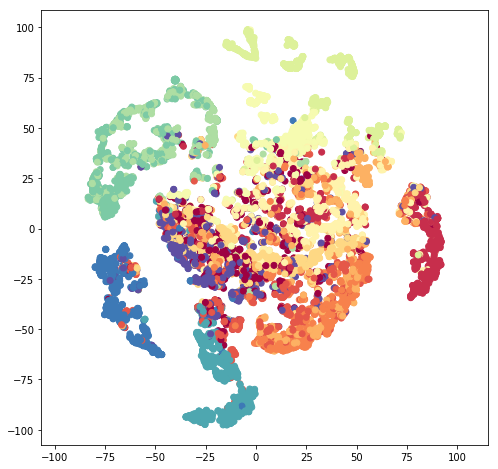

In [62]:
plt.subplots(figsize = (8, 8))
plt.axis('equal');

plt.scatter(nmf_df_tsne[0], nmf_df_tsne[1], c = dbpedia_df['Label'], cmap = plt.cm.Spectral)

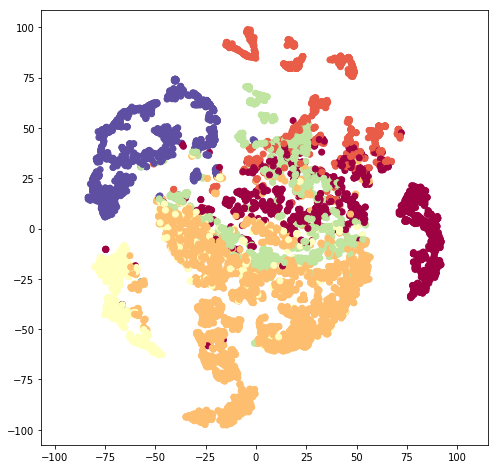

In [63]:
plt.subplots(figsize = (8, 8))
plt.axis('equal');

plt.scatter(nmf_df_tsne[0], nmf_df_tsne[1], c = dbpedia_df['Most_Likely_Topic'], cmap = plt.cm.Spectral)

In [59]:
df = pd.DataFrame(nmf_df_tsne)

df.columns = ['x', 'y']

df.head()

x          y
0 -23.496693 -26.695148
1 -35.902096 -16.684086
2  -4.424081  97.620346
3 -28.387108 -51.597744
4  -5.420871 -31.939760

In [60]:
df['topic'] = dbpedia_df['Most_Likely_Topic_Names']

df.head()

x          y                topic
0 -23.496693 -26.695148  album released film
1 -35.902096 -16.684086  album released film
2  -4.424081  97.620346  mi village district
3 -28.387108 -51.597744  album released film
4  -5.420871 -31.939760  album released film

In [61]:
source = ColumnDataSource(ColumnDataSource.from_df(df))

labels = LabelSet(x="x", y="y", text="topic", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)

show(plot, notebook_handle=True)